# Crime Analysis and Safety Prediction Modeling

<h3 align="right">Author: Sung Hyun Nam</h3> 

### Abstract

Many New York City visitors want to stay in the less expensive areas, but they are not always the safest. Currently finding an Airbnb is limited because visitors are not familiar with the city. This project aims to provide visitors a recommendation for choosing an Airbnb. This is important because visitors can make a better decision in choosing a safe but also affordable place to stay. In this project, I will explore the data, and explain algorithms and tools I used to achieve the result.

### 5 steps of this project
1. Data Collection and Preprocessing
2. Clustering Analysis
3. Classification Modeling
4. Prediction and Evaluation
5. Visualization

In [1]:
"""
Created on Wed Mar 22 23:18:32 2018

@author: Sung Hyun Nam
"""

import numpy as np
import pandas as pd
import sys
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Graphics
import io
import requests

from PIL import Image
import requests
from io import BytesIO

# Miscellenous
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# HTML display setting
display(HTML(data="""
<style> div#notebook-container { width: 60%; } div#menubar-container { width: 50%; } div#maintoolbar-container { width: 99%; } </style>
"""))

# Dataframe display setting
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.encoding = sys.stdout.encoding

# Data Collection and Preprocessing

#### Collecting crime data
For the crime analysis, we used the [New York City Crime Dataset](https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD) from the NYPD's open data webpage. We selected 7 features out of 24 original attributes, which includes the date and time of crime, level of the offense, and the geographic coordinates.

#### Collecting Airbnb data
For the Airbnb prediction, we used [Inside Airbnb website](http://insideairbnb.com/get-the-data.html) which is sourced from publicly available information from the Airbnb site. We selected 11 features out of 16 original attributes. The important features were the rental price, latitude and longitude coordinates.

#### Missing data handling
There were 2% and 0.2% of missing data in the crime and the Airbnb instances respectively. Missing values were handled either by deleting them or replacing them with another value.


In [3]:
url_crime = "https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD"
url_airbnb = "http://data.insideairbnb.com/united-states/ny/new-york-city/2018-03-04/visualisations/listings.csv"

s1 = requests.get(url_crime).content
s2 = requests.get(url_airbnb).content

data_crime = pd.read_csv(io.StringIO(s1.decode('utf-8')))
data_airbnb = pd.read_csv(io.StringIO(s2.decode('utf-8')))

## 1. Crime Data

The original dataset contains **24 attributes and 468,761 instances**.<br>
Below is the description of the features from the [footnote document](https://data.cityofnewyork.us/api/views/5uac-w243/files/fc4f191a-6adf-4268-a1ae-8525a8d7027b?download=true&filename=NYPDIncidentLevelDataFootnotes.pdf).

### Data Description

| Field Name | Description |
|:----------:|:-------------|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint |
| CMPLNT_FR_DT | Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) |
| CMPLNT_FR_TM | Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists) |
| CMPLNT_TO_DT | Ending date of occurrence for the reported event, if exact time of occurrence is unknown |
| CMPLNT_TO_TM | Ending time of occurrence for the reported event, if exact time of occurrence is unknown |
| RPT_DT | Date event was reported to police |
| KY_CD | Three digit offense classification code |
| OFNS_DESC | Description of offense corresponding with key code |
| PD_CD | Three digit internal classification code (more granular than Key Code) 
| PD_DESC | Description of internal classification corresponding with PD code (more granular than Offense Description) 
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely 
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation |
| JURIS_DESC | Jurisdiction responsible for incident. Either internal, like Police, Transit, and Housing; or external, like Correction, Port Authority, etc. 
| BORO_NM | The name of the borough in which the incident occurred 
| ADDR_PCT_CD |The precinct in which the incident occurred 
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of 
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. 
| PARKS_NM | Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included) 
| HADEVELOPT | Name of NYCHA housing development of occurrence, if applicable 
| X_COORD_CD | X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) 
| Y_COORD_CD | Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) 
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)

In [4]:
data_crime.head(6)

CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM      RPT_DT  KY_CD                       OFNS_DESC  PD_CD                         PD_DESC CRM_ATPT_CPTD_CD   LAW_CAT_CD           JURIS_DESC    BORO_NM  ADDR_PCT_CD LOC_OF_OCCUR_DESC               PREM_TYP_DESC PARKS_NM HADEVELOPT  X_COORD_CD  Y_COORD_CD  Latitude  Longitude Lat_Lon
0   579468609   12/31/2017     23:55:00          NaN          NaN  12/31/2017    118               DANGEROUS WEAPONS  792.0        WEAPONS POSSESSION 1 & 2        COMPLETED       FELONY     N.Y. POLICE DEPT   BROOKLYN           67               NaN                      STREET      NaN        NaN         NaN         NaN       NaN        NaN     NaN
1   822699000   12/31/2017     23:30:00          NaN          NaN  12/31/2017    344    ASSAULT 3 & RELATED OFFENSES  114.0             OBSTR BREATH/CIRCUL        COMPLETED  MISDEMEANOR     N.Y. POLICE DEPT      BRONX           47          FRONT OF      RESIDENCE - APT. HOUSE      NaN        NaN         NaN         NaN       NaN        NaN     NaN
2   187081621   12/31/2017     23:10:00   12/31/2017     23:15:00  12/31/2017    578                   HARRASSMENT 2  637.0      HARASSMENT,SUBD 1,CIVILIAN        COMPLETED    VIOLATION  N.Y. HOUSING POLICE  MANHATTAN           23            INSIDE  RESIDENCE - PUBLIC HOUSING      NaN        NaN         NaN         NaN       NaN        NaN     NaN
3   967006956   12/31/2017     23:05:00   12/31/2017     23:15:00  12/31/2017    118               DANGEROUS WEAPONS  793.0            WEAPONS POSSESSION 3        COMPLETED       FELONY     N.Y. POLICE DEPT   BROOKLYN           73            INSIDE             RESIDENCE-HOUSE      NaN        NaN         NaN         NaN       NaN        NaN     NaN
4   524297993   12/31/2017     23:00:00          NaN          NaN  12/31/2017    118               DANGEROUS WEAPONS  792.0        WEAPONS POSSESSION 1 & 2        COMPLETED       FELONY     N.Y. POLICE DEPT   BROOKLYN           61          FRONT OF      RESIDENCE - APT. HOUSE      NaN        NaN         NaN         NaN       NaN        NaN     NaN
5   656720558   12/31/2017     23:00:00          NaN          NaN  12/31/2017    351  CRIMINAL MISCHIEF & RELATED OF  254.0  MISCHIEF, CRIMINAL 4, OF MOTOR        COMPLETED  MISDEMEANOR     N.Y. POLICE DEPT   BROOKLYN           61            INSIDE                      STREET      NaN        NaN         NaN         NaN       NaN        NaN     NaN

### Missing Data Exploration

We sorted the percentage of missing values by the column.<br>
**Importantly, the instances with missing coordinates were 2.1% of the total dataset**.

In [5]:
missing = data_crime.isnull().sum().sort_values(ascending=False)
ratio = (data_crime.isnull().sum() / data_crime.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, ratio.round(3)*100], axis=1, keys=["Count", "Percentage"])

# Only show the columns with missing values
missing_data = missing_data[missing_data.Count != 0]

# Show the missing data per column
missing_data

Count  Percentage
PARKS_NM           464691        99.1
HADEVELOPT         444516        94.8
LOC_OF_OCCUR_DESC   90660        19.3
CMPLNT_TO_DT        73116        15.6
CMPLNT_TO_TM        72918        15.6
Longitude           10009         2.1
Lat_Lon             10009         2.1
X_COORD_CD          10009         2.1
Y_COORD_CD          10009         2.1
Latitude            10009         2.1
PREM_TYP_DESC        1815         0.4
PD_DESC               290         0.1
PD_CD                 290         0.1
OFNS_DESC              22         0.0

In [6]:
# Define a function to plot into a bar chart

def show_barchart(data, title, xlabel, ylabel):
    
    objects = data.index
    y_pos = np.arange(len(objects))
    performance = data
    
    fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.bar(y_pos, performance, width=0.7, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation=50)
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.title(title, size=20)

    plt.tight_layout()
    plt.show()

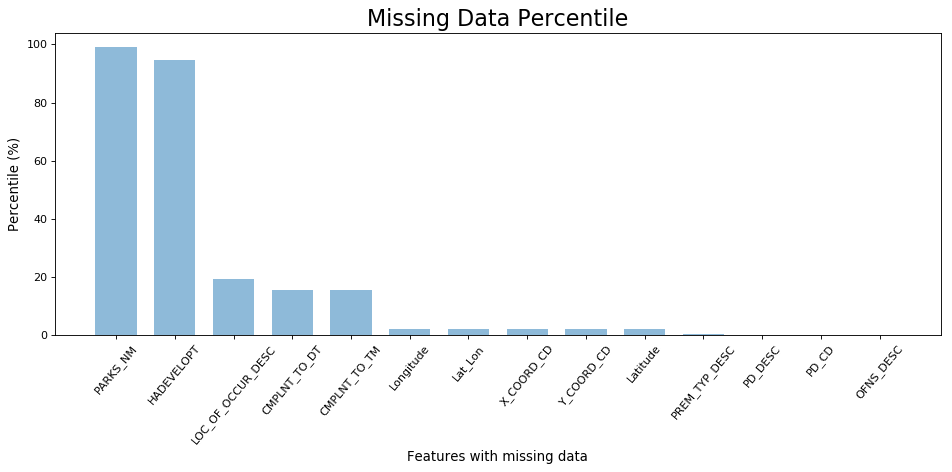

In [7]:
show_barchart(missing_data['Percentage'], 'Missing Data Percentile', 'Features with missing data', 'Percentile (%)')

### Feature Selection

First, the relevant features were selected regarding the modeling and visualization phase.<br>

In [8]:
# Select the columns to be used
df_select = data_crime[['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'KY_CD', "LAW_CAT_CD", "BORO_NM", "Latitude", "Longitude"]]

df_select.head(6)

CMPLNT_FR_DT CMPLNT_FR_TM  KY_CD   LAW_CAT_CD    BORO_NM  Latitude  Longitude
0   12/31/2017     23:55:00    118       FELONY   BROOKLYN       NaN        NaN
1   12/31/2017     23:30:00    344  MISDEMEANOR      BRONX       NaN        NaN
2   12/31/2017     23:10:00    578    VIOLATION  MANHATTAN       NaN        NaN
3   12/31/2017     23:05:00    118       FELONY   BROOKLYN       NaN        NaN
4   12/31/2017     23:00:00    118       FELONY   BROOKLYN       NaN        NaN
5   12/31/2017     23:00:00    351  MISDEMEANOR   BROOKLYN       NaN        NaN

### Cleaning Data

The crime data is cleaned thus having **7 attributes and 458,752 instances**.<br>


| Field Name | Description |
|:----------:|:---------------------------------------------------|
| Date | Date of occurrence for the reported event |
| Time | Time of occurrence for the reported event |
| Class | Three digit offense classification code |
| Level | Level of offense: felony, misdemeanor, violation |
| Borough | The name of the borough in which the incident occurred |
| Latitude | Latitude coordinate
| Longitude | Longitude coordinate

In [9]:
# Rename the columns
df_select.columns = ['Date', 'Time', 'Class', 'Level', 'Borough', 'Latitude', 'Longitude']

# Erase the rows with missing coordinates
df_crime = df_select[pd.notnull(df_select['Longitude'])]

# Reset index
df_crime = df_crime.reset_index(drop=True)

In [10]:
df_crime.head(6)

Date      Time  Class        Level    Borough   Latitude  Longitude
0  12/31/2017  12:30:00    344  MISDEMEANOR   BROOKLYN  40.651800 -74.012345
1  12/31/2017  01:00:00    109       FELONY      BRONX  40.821953 -73.928094
2  12/30/2017  15:10:00    105       FELONY  MANHATTAN  40.720892 -73.988818
3  12/30/2017  14:25:00    341  MISDEMEANOR  MANHATTAN  40.750431 -73.989282
4  12/30/2017  14:15:00    348  MISDEMEANOR     QUEENS  40.698443 -73.808546
5  12/30/2017  14:10:00    235  MISDEMEANOR  MANHATTAN  40.800880 -73.939979

## 2. AirBnB Data
AirBnB Data contains **16 attributes and 48,852 instances**.

### Data Description

| Field Name | Description |
|:----------:|:-------------|
|id| listing id
|review_scores_location| 0-5 stars converted into a 0-10 scale
|name| listing name
|host_id| host id
|host_name| host name
|neighbourhood_group| NYC borough
|neighbourhood| NYC neighborhood
|latitude| listing latitude
|longitude| listing longitude
|room_type| type of listing (Entire home/apt, Private room, Shared room)
|price| listing price
|minimum_nights| required minimum nights stay
|number_of_reviews| total number of reviews
|last_review| date of last review
|reviews per month| average number of reviews per month
|calculated_host_listings_count| total number of listings for this host
|availability_365| number of days listing is available out of 365

In [11]:
data_airbnb.head(6)

id                                 name  host_id    host_name neighbourhood_group neighbourhood   latitude  longitude        room_type  price  minimum_nights  number_of_reviews last_review  reviews_per_month  calculated_host_listings_count  availability_365
0  2515     Stay at Chez Chic budget room #1     2758         Mizi           Manhattan        Harlem  40.799205 -73.953676     Private room     59               2                164  2018-02-11               1.43                               3               316
1  2539   Clean & quiet apt home by the park     2787         John            Brooklyn    Kensington  40.647486 -73.972370     Private room     39               1                  7  2017-09-17               0.26                               7               365
2  2595                Skylit Midtown Castle     2845     Jennifer           Manhattan       Midtown  40.753621 -73.983774  Entire home/apt    225               1                 29  2018-01-01               0.29                               2               365
3  3330   ++ Brooklyn Penthouse Guestroom ++     4177        Julia            Brooklyn  Williamsburg  40.708558 -73.942362     Private room     70               5                 27  2017-12-12               0.27                               3               279
4  3647  THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth           Manhattan        Harlem  40.809018 -73.941902     Private room    150               3                  0         NaN                NaN                               1               365
5  3831      Cozy Entire Floor of Brownstone     4869  LisaRoxanne            Brooklyn  Clinton Hill  40.685138 -73.959757  Entire home/apt     89               1                181  2018-02-24               4.34                               1               126

### Missing Data

In order to handle the instances having a missing value, the missing value percentages for each column are sorted.<br>
In this case, the missing data was not a critical matter.

In [12]:
missing = data_airbnb.isnull().sum().sort_values(ascending=False)
ratio = (data_airbnb.isnull().sum() / data_airbnb.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, ratio.round(3)*100], axis=1, keys=["Count", "Percentage"])

# Only show the columns with missing values
missing_data = missing_data[missing_data.Count != 0]

missing_data

Count  Percentage
reviews_per_month  10936        22.4
last_review        10880        22.3
host_name            106         0.2
name                  28         0.1

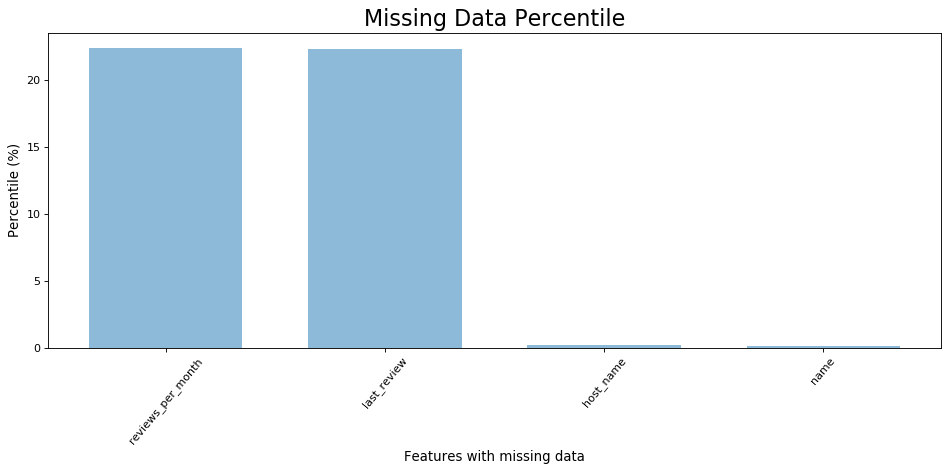

In [13]:
show_barchart(missing_data['Percentage'], 'Missing Data Percentile', 'Features with missing data', 'Percentile (%)')

In [14]:
# Select the columns to be used
df_airbnb = data_airbnb.drop(['id', 'host_id', 'minimum_nights', 'last_review', 'reviews_per_month'], 1).reset_index(drop=True)

# Replace the values of missing name and host_name
df_airbnb.name = df_airbnb.name.fillna(df_airbnb['neighbourhood_group']+' '+df_airbnb['neighbourhood']+' '+df_airbnb['room_type'])
df_airbnb.host_name = df_airbnb.host_name.fillna('Host')

# Reset index
df_airbnb = df_airbnb.reset_index(drop=True)

df_airbnb.head(6)

name    host_name neighbourhood_group neighbourhood   latitude  longitude        room_type  price  number_of_reviews  calculated_host_listings_count  availability_365
0     Stay at Chez Chic budget room #1         Mizi           Manhattan        Harlem  40.799205 -73.953676     Private room     59                164                               3               316
1   Clean & quiet apt home by the park         John            Brooklyn    Kensington  40.647486 -73.972370     Private room     39                  7                               7               365
2                Skylit Midtown Castle     Jennifer           Manhattan       Midtown  40.753621 -73.983774  Entire home/apt    225                 29                               2               365
3   ++ Brooklyn Penthouse Guestroom ++        Julia            Brooklyn  Williamsburg  40.708558 -73.942362     Private room     70                 27                               3               279
4  THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth           Manhattan        Harlem  40.809018 -73.941902     Private room    150                  0                               1               365
5      Cozy Entire Floor of Brownstone  LisaRoxanne            Brooklyn  Clinton Hill  40.685138 -73.959757  Entire home/apt     89                181                               1               126

# Clustering

We applied K-Means on the crime longitude and latitudes to group the points into fifty clusters, and used the centroids to represent each cluster. 

In [15]:
X = df_crime[['Longitude', 'Latitude']].values

kmns = KMeans(n_clusters=50, init='k-means++', precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')
kY = kmns.fit_predict(X)

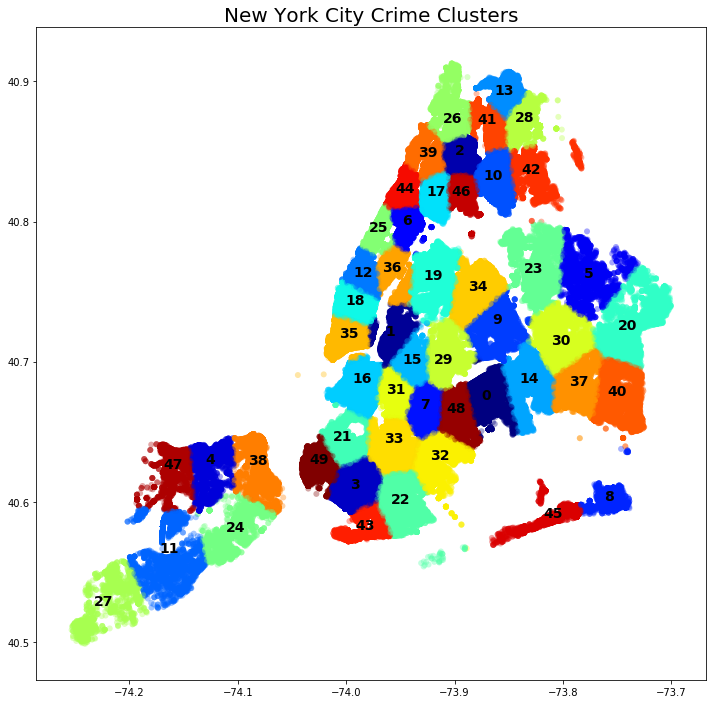

In [16]:
fig=plt.figure(figsize=(12, 12))

plt.scatter(X[:,0], X[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=14, horizontalalignment='center', weight='bold')

plt.title('New York City Crime Clusters', size=20)

# 50 Clusters
plt.show()

### Google map<br>


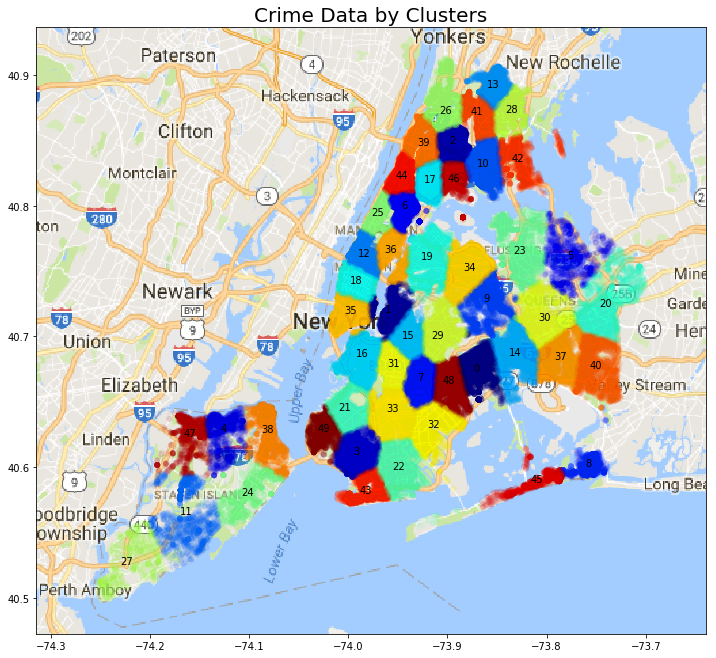

In [17]:
fig=plt.figure(figsize=(12, 12))

url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, zorder=0, extent=[-74.414690, -73.539312, 40.372528, 41.036494], aspect=1.31841)

plt.scatter(X[:,0], X[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.05)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=10, horizontalalignment='center')

plt.title('Crime Data by Clusters', size=20)

(xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()

axes = plt.gca()
axes.set_xlim([xmin+0.1,xmax-0.1])
axes.set_ylim([ymin+0.1,ymax-0.1])

plt.show()

## Clustering Analysis

To predict the safety rating of each cluster, we calculated two different parameters, the number of crime and the level of crime within the clusters.<br> The three levels of crime, Felony, Misdemeanor, and Violation, were changed into numeric values 20, 5, and 1 respectively.<br> The weights are assigned according to the [New York State Law](http://ypdcrime.com/penal.law/article80.htm#p80.05) where it sentences to pay a fine for each level of crime shall be \$5,000, \$1,000 and \$250 respectively.

### 1. Number of crime per cluster

Calculated the incidents by cluster and sorted the values.

In [18]:
df_crime_cluster = pd.DataFrame(np.array(np.hstack((df_crime, np.array([kY]).T))), columns=list(df_crime.columns) + ['Cluster'])
df_crime_cluster.head(6)

Date      Time Class        Level    Borough Latitude Longitude Cluster
0  12/31/2017  12:30:00   344  MISDEMEANOR   BROOKLYN  40.6518  -74.0123      21
1  12/31/2017  01:00:00   109       FELONY      BRONX   40.822  -73.9281      17
2  12/30/2017  15:10:00   105       FELONY  MANHATTAN  40.7209  -73.9888      35
3  12/30/2017  14:25:00   341  MISDEMEANOR  MANHATTAN  40.7504  -73.9893      18
4  12/30/2017  14:15:00   348  MISDEMEANOR     QUEENS  40.6984  -73.8085      30
5  12/30/2017  14:10:00   235  MISDEMEANOR  MANHATTAN  40.8009    -73.94       6

In [19]:
df_crime_number = df_crime_cluster[['Cluster', 'Longitude']].groupby(['Cluster']).agg('count')
df_crime_number.columns=['Crime']

# number of crime per cluster
df_crime_number.head(6)

Crime
Cluster       
0         9865
1         7591
2        14979
3         6278
4         3735
5         3062

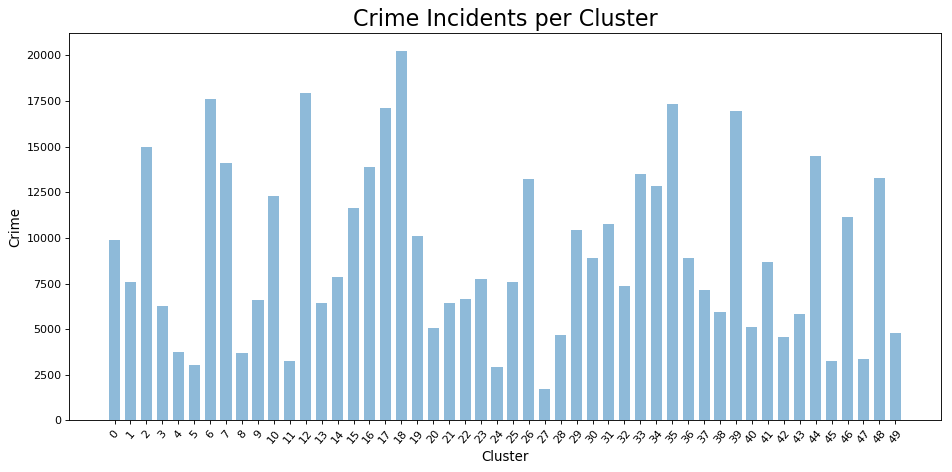

In [20]:
show_barchart(df_crime_number['Crime'], 'Crime Incidents per Cluster', 'Cluster', 'Crime')

In [21]:
scaler = MinMaxScaler(feature_range=(500,2000))
df_crime_number_p = pd.DataFrame(scaler.fit_transform(df_crime_number), columns=['Crime'])
df_crime_number_p

Crime
0   1160.084283
1    975.795559
2   1574.531309
3    869.387865
4    663.298936
5    608.757902
6   1787.265655
7   1504.511319
8    659.571020
9    893.457237
10  1356.853423
11   624.074774
12  1813.928359
13   880.409530
14   998.811389
15  1303.528013
16  1484.007780
17  1748.608785
18  2000.000000
19  1178.237614
20   771.651629
21   882.678697
22   897.914528
23   987.627641
24   598.465611
25   977.254309
26  1432.303204
27   500.000000
28   742.071425
29  1205.224485
30  1079.853044
31  1233.508023
32   955.616187
33  1453.374034
34  1402.155708
35  1764.736074
36  1082.932627
37   939.164731
38   842.319952
39  1732.076287
40   776.595170
41  1062.267005
42   731.860176
43   834.053704
44  1535.064023
45   623.345400
46  1261.953644
47   632.989357
48  1434.734454
49   749.527257

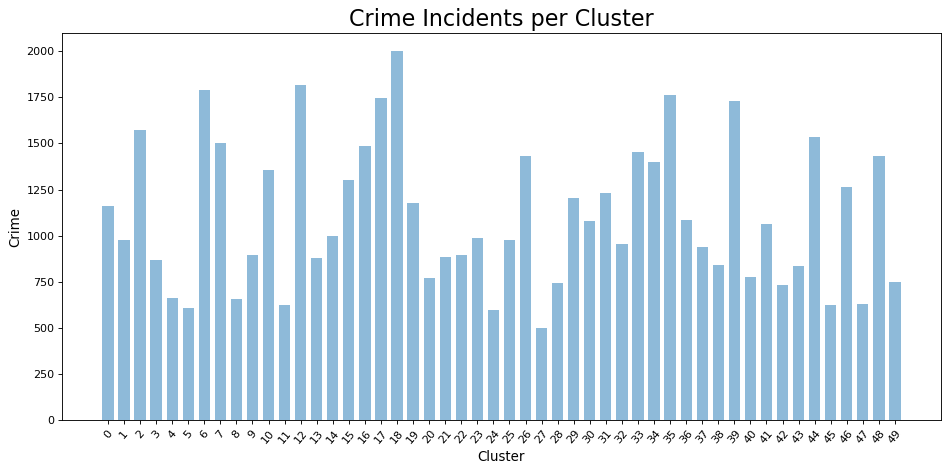

In [22]:
show_barchart(df_crime_number_p['Crime'], 'Crime Incidents per Cluster', 'Cluster', 'Crime')

### 2. Level of crime per cluster

Calculated the class of the crime by cluster and sorted the values.<br>
Each cluster has below portions.

In [23]:
df_crime_level = df_crime_cluster.groupby(["Cluster", "Level"]).agg({'Longitude':'count'}).rename(columns={'Longitude':'Count'})
df_crime_level

Count
Cluster Level             
0       FELONY        3276
        MISDEMEANOR   5129
        VIOLATION     1460
1       FELONY        2307
        MISDEMEANOR   4216
        VIOLATION     1068
2       FELONY        4094
        MISDEMEANOR   8530
        VIOLATION     2355
3       FELONY        1974
        MISDEMEANOR   3446
        VIOLATION      858
4       FELONY         852
        MISDEMEANOR   2052
        VIOLATION      831
5       FELONY        1100
        MISDEMEANOR   1448
        VIOLATION      514
6       FELONY        4817
        MISDEMEANOR  10502
        VIOLATION     2285
7       FELONY        4479
        MISDEMEANOR   7204
        VIOLATION     2432
8       FELONY        1367
        MISDEMEANOR   1677
        VIOLATION      645
9       FELONY        1888
        MISDEMEANOR   3824
        VIOLATION      863
...                    ...
40      FELONY        1930
        MISDEMEANOR   2276
        VIOLATION      927
41      FELONY        2402
        MISDEMEANOR   4986
        VIOLATION     1270
42      FELONY        1051
        MISDEMEANOR   2598
        VIOLATION      932
43      FELONY        1525
        MISDEMEANOR   3521
        VIOLATION      796
44      FELONY        3871
        MISDEMEANOR   8475
        VIOLATION     2146
45      FELONY        1163
        MISDEMEANOR   1600
        VIOLATION      479
46      FELONY        3395
        MISDEMEANOR   6170
        VIOLATION     1557
47      FELONY         715
        MISDEMEANOR   1975
        VIOLATION      671
48      FELONY        4468
        MISDEMEANOR   6699
        VIOLATION     2087
49      FELONY        1345
        MISDEMEANOR   2806
        VIOLATION      648

[150 rows x 1 columns]

Levels are changed into a numeric values in order to calculate the mean statistics.<br>

In [24]:
df_crime_cluster['Level'] = df_crime_cluster['Level'].replace({'FELONY': 20, 'MISDEMEANOR': 4, 'VIOLATION': 1})

In [25]:
df_crime_level = df_crime_cluster.groupby(["Cluster", "Level"]).agg({'Longitude':'count'}).rename(columns={'Longitude':'Count'})
df_crime_level

Count
Cluster Level       
0       1       1460
        4       5129
        20      3276
1       1       1068
        4       4216
        20      2307
2       1       2355
        4       8530
        20      4094
3       1        858
        4       3446
        20      1974
4       1        831
        4       2052
        20       852
5       1        514
        4       1448
        20      1100
6       1       2285
        4      10502
        20      4817
7       1       2432
        4       7204
        20      4479
8       1        645
        4       1677
        20      1367
9       1        863
        4       3824
        20      1888
...              ...
40      1        927
        4       2276
        20      1930
41      1       1270
        4       4986
        20      2402
42      1        932
        4       2598
        20      1051
43      1        796
        4       3521
        20      1525
44      1       2146
        4       8475
        20      3871
45      1        479
        4       1600
        20      1163
46      1       1557
        4       6170
        20      3395
47      1        671
        4       1975
        20       715
48      1       2087
        4       6699
        20      4468
49      1        648
        4       2806
        20      1345

[150 rows x 1 columns]

In [26]:
df_crime_level = df_crime_cluster.groupby(["Cluster"]).agg({'Level':'mean'}).rename(columns={'Level':'Mean Level'})
df_crime_level

Mean Level
Cluster            
0          8.869336
1          8.440522
2          7.901395
3          8.620898
4          6.982329
5          9.244285
6          7.988696
7          8.560255
8          9.404446
9          8.200608
10         7.706012
11         6.982775
12         8.986227
13         8.590115
14         8.388190
15         8.649592
16         8.417544
17         7.922111
18         9.098967
19         8.073645
20         9.583793
21         8.944893
22         8.773152
23         8.202792
24         6.727768
25         8.519516
26         8.356700
27         7.117442
28         7.776928
29         8.668202
30         8.738141
31         8.985702
32         8.815582
33         8.816597
34         8.679272
35         8.499827
36         9.269157
37         8.705001
38         6.851783
39         8.184364
40         9.474187
41         7.998845
42         7.060467
43         7.767888
44         7.829561
45         9.296422
46         8.464035
47         6.804820
48         8.921307
49         8.079183

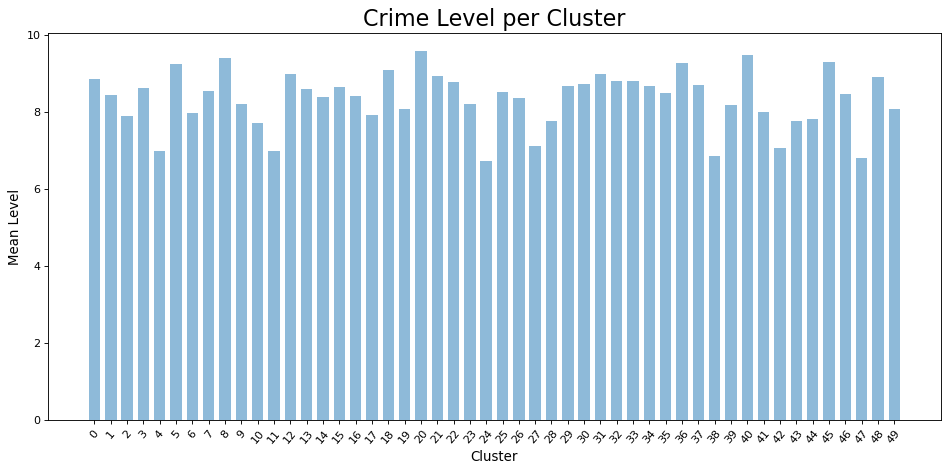

In [27]:
show_barchart(df_crime_level['Mean Level'], 'Crime Level per Cluster', 'Cluster', 'Mean Level')

### Normalization using min-max scaler
We normalized these two parameters using Min-Max scaler function from scikit-learn.

In [28]:
scaler = MinMaxScaler(feature_range=(0.5,2))
df_crime_level_p = pd.DataFrame(scaler.fit_transform(df_crime_level), columns=['Level'])
df_crime_level_p

Level
0   1.624763
1   1.399547
2   1.116395
3   1.494282
4   0.633697
5   1.821688
6   1.162246
7   1.462432
8   1.905806
9   1.273544
10  1.013779
11  0.633931
12  1.686155
13  1.478115
14  1.372063
15  1.509352
16  1.387480
17  1.127275
18  1.745366
19  1.206862
20  2.000000
21  1.664446
22  1.574247
23  1.274690
24  0.500000
25  1.441036
26  1.355524
27  0.704659
28  1.051024
29  1.519126
30  1.555859
31  1.685879
32  1.596531
33  1.597064
34  1.524940
35  1.430695
36  1.834751
37  1.538453
38  0.565133
39  1.265012
40  1.942434
41  1.167576
42  0.674735
43  1.046276
44  1.078668
45  1.849071
46  1.411897
47  0.540468
48  1.652058
49  1.209770

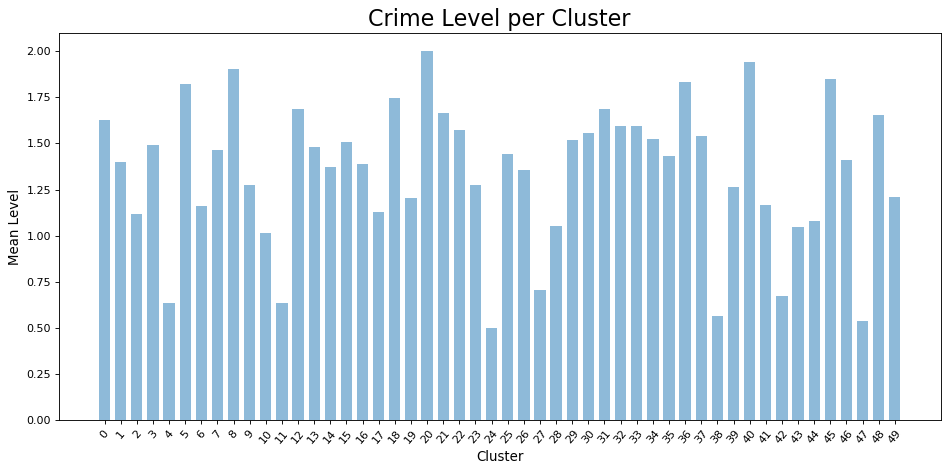

In [29]:
show_barchart(df_crime_level_p['Level'], 'Crime Level per Cluster', 'Cluster', 'Mean Level')

In [30]:
df_y = pd.DataFrame(np.array(np.hstack((df_crime_number_p, np.array([df_crime_level_p['Level']]).T))), columns=list(df_crime_number.columns) + ['Level'])
df_y['Target'] = df_y['Crime'] * df_y['Level']
df_y['Target'] = df_y['Target']
df_y.head(10)

Crime     Level       Target
0  1160.084283  1.624763  1884.862129
1   975.795559  1.399547  1365.672177
2  1574.531309  1.116395  1757.799373
3   869.387865  1.494282  1299.110876
4   663.298936  0.633697   420.330435
5   608.757902  1.821688  1108.967103
6  1787.265655  1.162246  2077.242347
7  1504.511319  1.462432  2200.245597
8   659.571020  1.905806  1257.014137
9   893.457237  1.273544  1137.856799

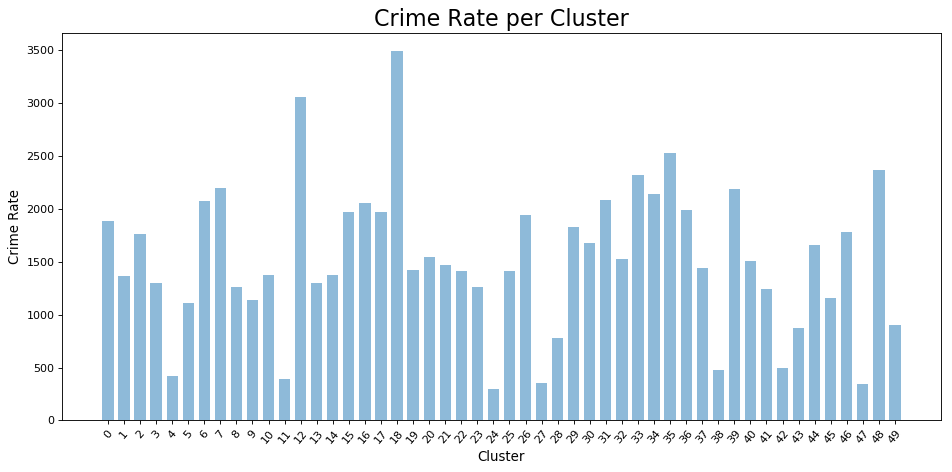

In [31]:
show_barchart(df_y['Target'], 'Crime Rate per Cluster', 'Cluster', 'Crime Rate')

## Plot the target (safety) result

In [32]:
### Let's plot
dat = df_y['Target']

# min, max, and border
c_min, c_max = dat.values.min(), dat.values.max()+1
crime_range = np.linspace(c_min, c_max, 6)

cluster_dict = dict(zip(dat.index.values, dat.values))

# dictionary of clusters and corresponding number of crime
sorted_x = dict(sorted(cluster_dict.items(), key=lambda x: x[1]))

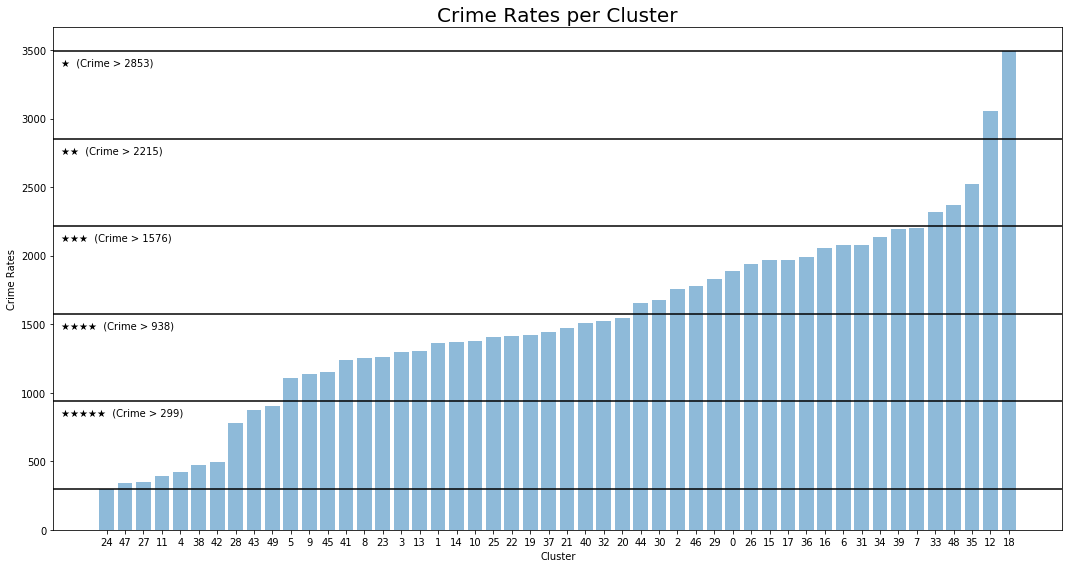

In [33]:
fig=plt.figure(figsize=(15, 8))

objects = sorted_x.keys()
y_pos = np.arange(len(objects))
performance = sorted_x.values()
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Crime Rates')
plt.xlabel('Cluster')
plt.title('Crime Rates per Cluster', size=20)

for i, border in enumerate(crime_range):
    plt.axhline(y=border, c='black', hold=None)
    if i<5:
        plt.text(-2.5, border+(c_max-c_min)/6, "★"*(5-i)+'  (Crime > %.0f)' % border, size=10)
    
plt.tight_layout()
plt.show()

In [34]:
df_y['Safety'] = 6 - ((df_y['Target'] - c_min) // ((c_max-c_min)/5) + 1)
df_y

Crime     Level       Target  Safety
0   1160.084283  1.624763  1884.862129     3.0
1    975.795559  1.399547  1365.672177     4.0
2   1574.531309  1.116395  1757.799373     3.0
3    869.387865  1.494282  1299.110876     4.0
4    663.298936  0.633697   420.330435     5.0
5    608.757902  1.821688  1108.967103     4.0
6   1787.265655  1.162246  2077.242347     3.0
7   1504.511319  1.462432  2200.245597     3.0
8    659.571020  1.905806  1257.014137     4.0
9    893.457237  1.273544  1137.856799     4.0
10  1356.853423  1.013779  1375.549105     4.0
11   624.074774  0.633931   395.620135     5.0
12  1813.928359  1.686155  3058.563666     1.0
13   880.409530  1.478115  1301.346421     4.0
14   998.811389  1.372063  1370.431962     4.0
15  1303.528013  1.509352  1967.482863     3.0
16  1484.007780  1.387480  2059.030572     3.0
17  1748.608785  1.127275  1971.163788     3.0
18  2000.000000  1.745366  3490.732887     1.0
19  1178.237614  1.206862  1421.969703     4.0
20   771.651629  2.000000  1543.303258     4.0
21   882.678697  1.664446  1469.170997     4.0
22   897.914528  1.574247  1413.539152     4.0
23   987.627641  1.274690  1258.919473     4.0
24   598.465611  0.500000   299.232806     5.0
25   977.254309  1.441036  1408.258528     4.0
26  1432.303204  1.355524  1941.521094     3.0
27   500.000000  0.704659   352.329340     5.0
28   742.071425  1.051024   779.935175     5.0
29  1205.224485  1.519126  1830.888254     3.0
30  1079.853044  1.555859  1680.098712     3.0
31  1233.508023  1.685879  2079.545665     3.0
32   955.616187  1.596531  1525.670830     4.0
33  1453.374034  1.597064  2321.132074     2.0
34  1402.155708  1.524940  2138.203701     3.0
35  1764.736074  1.430695  2524.798806     2.0
36  1082.932627  1.834751  1986.912228     3.0
37   939.164731  1.538453  1444.861056     4.0
38   842.319952  0.565133   476.023101     5.0
39  1732.076287  1.265012  2191.097771     3.0
40   776.595170  1.942434  1508.484816     4.0
41  1062.267005  1.167576  1240.277923     4.0
42   731.860176  0.674735   493.811858     5.0
43   834.053704  1.046276   872.650708     5.0
44  1535.064023  1.078668  1655.823862     3.0
45   623.345400  1.849071  1152.609876     4.0
46  1261.953644  1.411897  1781.748437     3.0
47   632.989357  0.540468   342.110469     5.0
48  1434.734454  1.652058  2370.265121     2.0
49   749.527257  1.209770   906.755948     5.0

In [35]:
safeY = []
for x in kY:
    safeY.append(df_y['Safety'][x])

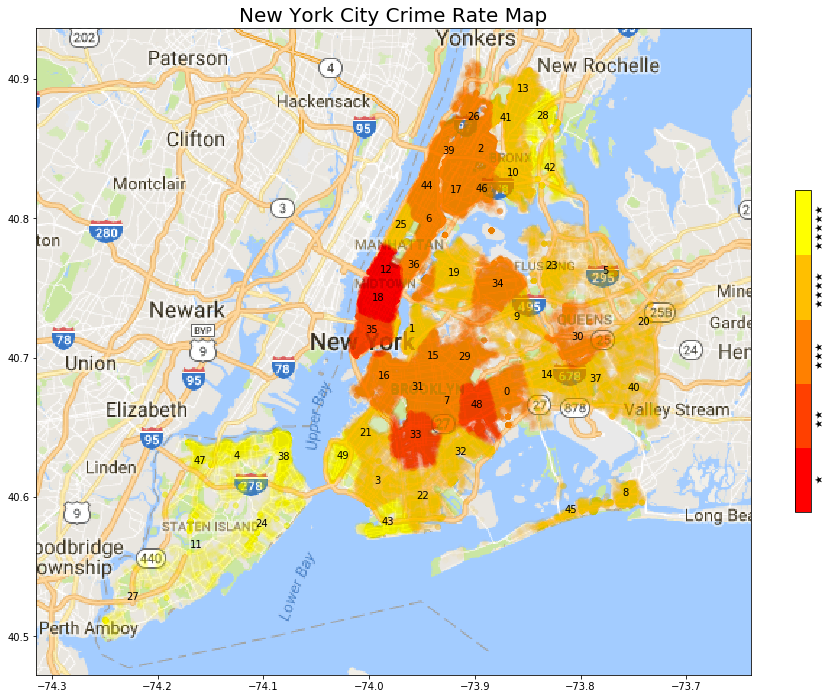

In [36]:
fig=plt.figure(figsize=(16, 16))

url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, zorder=0, extent=[-74.414690, -73.539312, 40.372528, 41.036494], aspect=1.31841)

plt.scatter(X[:,0], X[:,1],  c=safeY, cmap = plt.cm.get_cmap('autumn',5), edgecolor = "None", alpha=0.02)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=10, horizontalalignment='center')

color_bar = plt.colorbar(ticks=[], label='     ★               ★★             ★★★           ★★★★       ★★★★★', shrink=0.37)
color_bar.set_alpha(50)
color_bar.draw_all()
plt.title('New York City Crime Rate Map', size=20)

(xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()

axes = plt.gca()
axes.set_xlim([xmin+0.1,xmax-0.1])
axes.set_ylim([ymin+0.1,ymax-0.1])

plt.show()

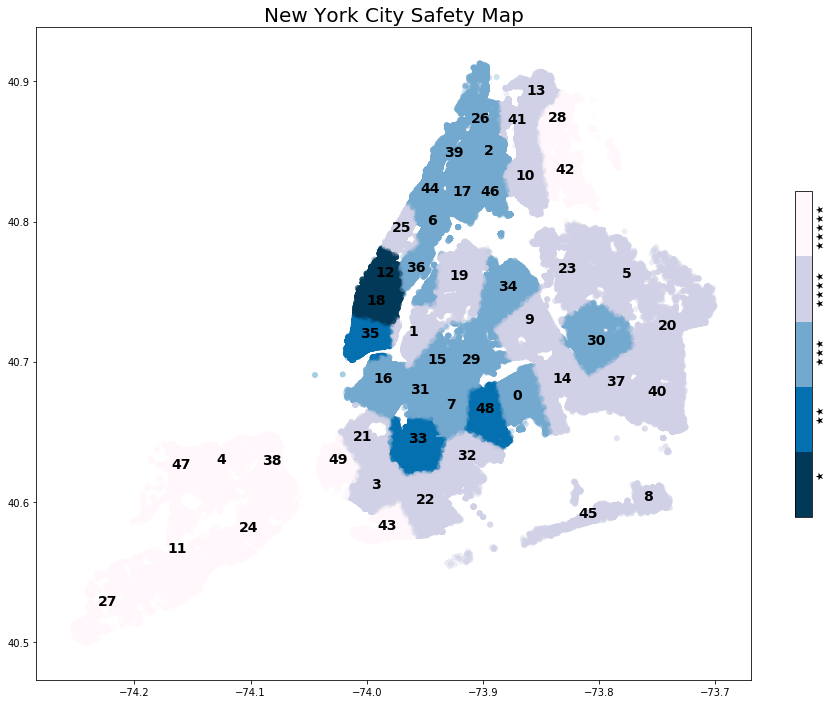

In [37]:
fig=plt.figure(figsize=(16, 12))
plt.scatter(X[:,0], X[:,1],  c=safeY, cmap = plt.cm.get_cmap('PuBu_r',5), edgecolor = "None", alpha=0.35)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=14, horizontalalignment='center', weight='bold')

color_bar = plt.colorbar(ticks=[], label='        ★               ★★             ★★★          ★★★★       ★★★★★', shrink=0.5)
color_bar.set_alpha(3)
color_bar.draw_all()
plt.title('New York City Safety Map', size=20)
plt.show()

# Modeling - Classification

1. K-nearest neighbour
2. Support Vector Machine
3. Random Forest

Let's first take a look at the dataset we are going to fit.

In [38]:
# X
df_X = df_crime_cluster[['Latitude', 'Longitude']]
df_X

Latitude Longitude
0       40.6518  -74.0123
1        40.822  -73.9281
2       40.7209  -73.9888
3       40.7504  -73.9893
4       40.6984  -73.8085
5       40.8009    -73.94
6       40.6642  -73.9084
7       40.6636  -73.9911
8        40.661  -73.9974
9       40.6243  -74.1518
10      40.7461  -73.9789
11       40.744  -74.0069
12       40.702  -73.7417
13      40.8071  -73.9438
14      40.7574   -73.834
15      40.8177  -73.9154
16      40.8105  -73.9519
17      40.7378  -74.0045
18      40.8231  -73.9424
19      40.6516  -73.9753
20      40.6904  -73.9848
21      40.7276   -73.953
22      40.5718  -74.1114
23      40.7493  -73.8785
24      40.6256  -73.9466
25      40.6233  -73.9452
26      40.6233  -73.9452
27       40.817  -73.9212
28      40.6381  -74.1661
29      40.6871  -73.9492
...         ...       ...
458722  40.8314  -73.9357
458723  40.7168  -74.0087
458724  40.6589  -73.8898
458725  40.6091  -73.9508
458726  40.6252  -73.9189
458727  40.8754   -73.876
458728  40.6269  -74.1634
458729  40.6157  -73.8992
458730  40.6232  -74.1492
458731  40.8776  -73.8729
458732  40.7124   -73.851
458733  40.7623  -73.9586
458734  40.7078  -74.0117
458735  40.6333   -73.968
458736   40.854  -73.8276
458737   40.891  -73.8329
458738  40.6102  -73.9733
458739  40.6674  -73.9034
458740  40.7267  -73.9916
458741  40.6155  -73.9779
458742  40.6636  -73.9555
458743  40.7016   -73.938
458744  40.6666  -73.8869
458745  40.7818  -73.9473
458746  40.8481  -73.9015
458747  40.6709  -73.9365
458748  40.6764  -73.8041
458749  40.7221  -73.9587
458750  40.8901  -73.8558
458751  40.6137  -73.9816

[458752 rows x 2 columns]

In [39]:
df_y = pd.DataFrame(safeY)
df_y.columns=['Safety']
df_y

Safety
0          4.0
1          3.0
2          2.0
3          1.0
4          3.0
5          3.0
6          2.0
7          3.0
8          4.0
9          5.0
10         1.0
11         1.0
12         4.0
13         3.0
14         4.0
15         3.0
16         3.0
17         1.0
18         3.0
19         2.0
20         3.0
21         4.0
22         5.0
23         3.0
24         2.0
25         2.0
26         2.0
27         3.0
28         5.0
29         3.0
...        ...
458722     3.0
458723     2.0
458724     2.0
458725     4.0
458726     4.0
458727     4.0
458728     5.0
458729     4.0
458730     5.0
458731     4.0
458732     4.0
458733     3.0
458734     2.0
458735     2.0
458736     5.0
458737     5.0
458738     4.0
458739     2.0
458740     2.0
458741     4.0
458742     3.0
458743     3.0
458744     2.0
458745     3.0
458746     3.0
458747     3.0
458748     4.0
458749     4.0
458750     4.0
458751     4.0

[458752 rows x 1 columns]

In [40]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['Safety'], train_size=0.008, test_size=0.002, random_state=True)

In [41]:
# Naive Bayesian
start_time = time.time()

nb = BernoulliNB()
nb.fit(X_train, y_train)

# training score
y_pred = nb.predict(X_train).round()
train_score = accuracy_score(y_train, y_pred)
print('train score: {:.1f}%'.format(train_score*100))

# test score
y_pred = nb.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('test score: {:.1f}%'.format(test_score*100))

# cv score
cv_score = cross_val_score(nb, X_test, y_test, cv=10)
print('cross-validated test score: {:.1f}%'.format(np.mean(cv_score)*100))

# running time
print("running time: %.2f seconds" % (time.time() - start_time))

train score: 45.0%
test score: 46.2%
cross-validated test score: 46.2%
running time: 0.05 seconds


In [42]:
# KNN
start_time = time.time()

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(5, 30)), 'weights': ['uniform', 'distance'], 'algorithm' : ['auto', 'ball_tree', 'kd_tree']}

# hyper-parameter tuning
rand_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
rand_knn.fit(X_train, y_train)

# training score
y_pred = rand_knn.predict(X_train).round()
train_score = accuracy_score(y_train, y_pred)
print('train score: {:.1f}%'.format(train_score*100))

# test score
y_pred = rand_knn.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('test score: {:.1f}%'.format(test_score*100))

# cv score
print('cross-validated test score: {:.1f}%'.format(rand_knn.best_score_*100))

# best parameters
print('best params:', rand_knn.best_params_)

# running time
print("running time: %.2f seconds" % (time.time() - start_time))

train score: 100.0%
test score: 97.6%
cross-validated test score: 98.5%
best params: {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'distance'}
running time: 48.10 seconds


In [43]:
# SVM
start_time = time.time()

svm = SVC()
param_grid = {'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'sigmoid']}

# hyper-parameter tuning
rand_svm = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
rand_svm.fit(X_train, y_train)

# training score
y_pred = rand_svm.predict(X_train).round()
train_score = accuracy_score(y_train, y_pred)
print('train score: {:.1f}%'.format(train_score*100))

# test score
y_pred = rand_svm.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('test accuracy: {:.1f}%'.format(test_score*100))

# cv score
print('cross-validated test score: {:.1f}%'.format(rand_svm.best_score_*100))

# best parameters
print('best params:', rand_svm.best_params_)

# running time
print("running time: %.2f seconds" % (time.time() - start_time))

train score: 56.0%
test accuracy: 56.9%
cross-validated test score: 55.9%
best params: {'C': 1, 'kernel': 'linear'}
running time: 29.54 seconds


In [44]:
# Random Forest
start_time = time.time()

rfc = RandomForestClassifier()
param_grid = {"n_estimators": list(range(10,20)), "max_depth": [None, 2, 5]}

# hyper-parameter tuning
rand_rfc = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy')
rand_rfc.fit(X_train, y_train)

# training score
y_pred = rand_rfc.predict(X_train).round()
train_score = accuracy_score(y_train, y_pred)
print('train score: {:.1f}%'.format(train_score*100))

# test score
y_pred = rand_rfc.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('test accuracy: {:.1f}%'.format(test_score*100))

# cv score
print('cross-validated test score: {:.1f}%'.format(rand_rfc.best_score_*100))

# best parameters
print('best params:', rand_rfc.best_params_)

# running time
print("running time: %.2f seconds" % (time.time() - start_time))

train score: 99.8%
test accuracy: 97.1%
cross-validated test score: 98.0%
best params: {'max_depth': None, 'n_estimators': 10}
running time: 12.57 seconds


# Plotting the decision boundaries

In [45]:
url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

ext = [-74.414690, -73.539312, 40.372528, 41.036494]

In [46]:
# step size in the mesh
h = .005

# create the mesh
x_min, x_max, y_min, y_max = ext
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [47]:
Z = []

for cls in [rand_knn, rand_svm, rand_rfc]:
    Z.append(cls.predict(np.c_[yy.ravel(), xx.ravel()]))
    
name = ['K Nearest Neighbors', 'Support Vector Machine', 'Random Forest']

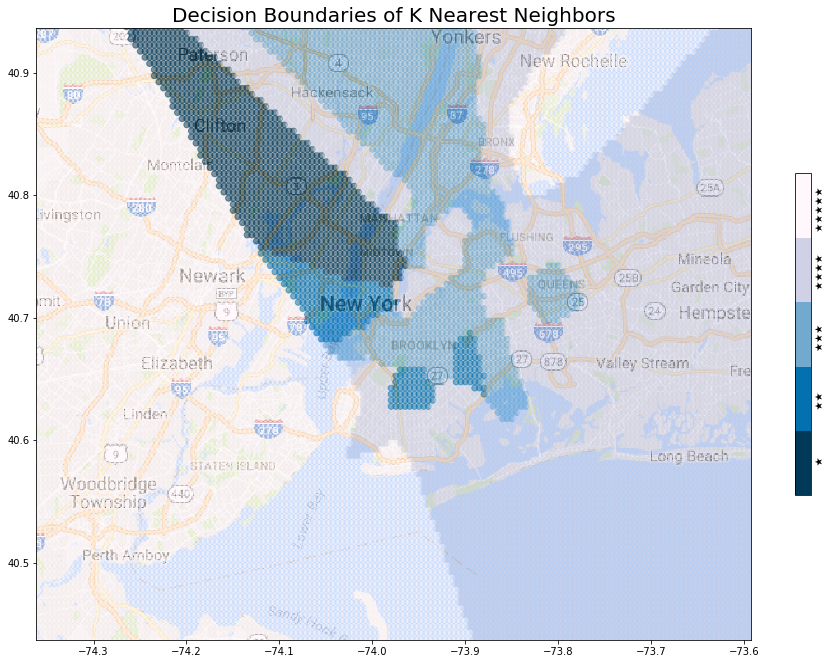

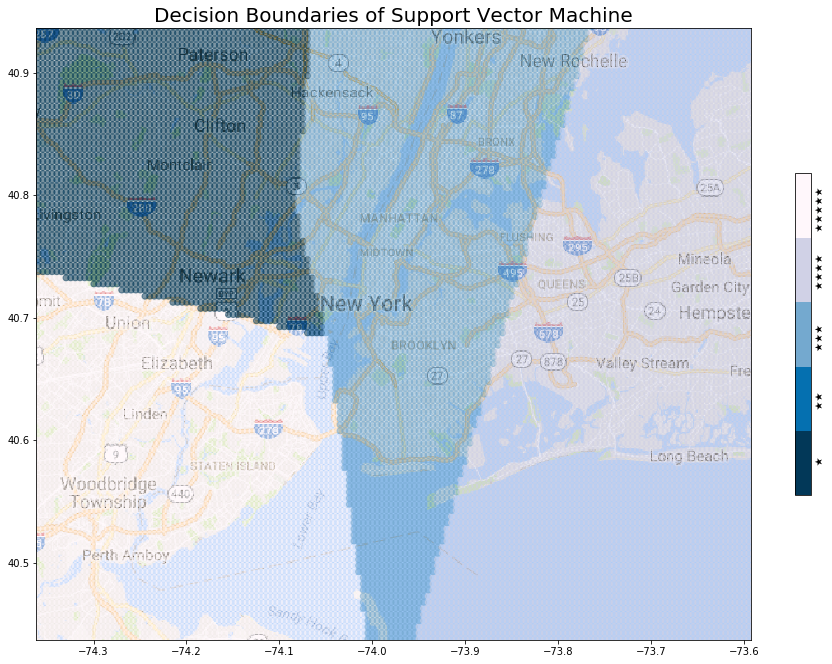

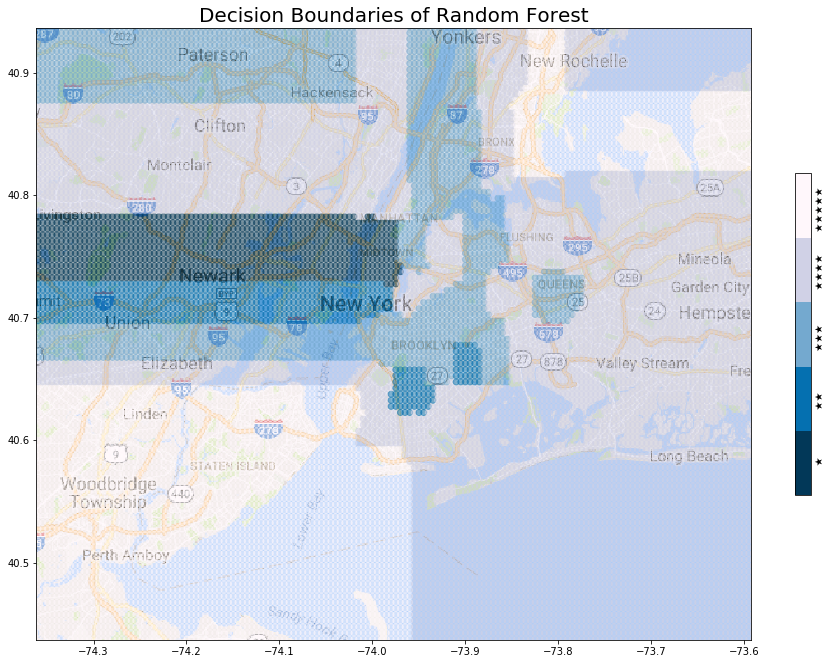

In [48]:
for item, name in zip(Z, name):
    fig=plt.figure(figsize=(16, 16))

    # background image
    plt.imshow(img, zorder=0, extent=ext, aspect=(ext[1]-ext[0])/(ext[3]-ext[2]))
    
    # Put the result into a color plot
    item = item.reshape(xx.shape)
    #ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    plt.scatter(xx, yy, c=item, cmap = plt.cm.get_cmap('PuBu_r',5), alpha=0.5)

    # Draw colorbar    
    color_bar = plt.colorbar(ticks=[], label='     ★               ★★             ★★★           ★★★★       ★★★★★', shrink=0.37)
    color_bar.set_alpha(50)
    color_bar.draw_all()
    plt.title('Decision Boundaries of '+name, size=20)

    # readjust the scale of the map
    (xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()

    axes = plt.gca()
    axes.set_xlim([xmin+0.1,xmax-0.1])
    axes.set_ylim([ymin+0.1,ymax-0.1])

    plt.show()

In [49]:
'''
Airbnb Safety Calculation
'''

'\nAirbnb Safety Calculation\n'

In [50]:
kY_airbnb = rand_knn.predict(df_airbnb[['longitude', 'latitude']])

column = list(df_airbnb.columns)
column.append('Safety')

df_airbnb_safety = pd.DataFrame(np.concatenate((df_airbnb, np.array([kY_airbnb]).T), axis=1), columns=column)
df_airbnb_safety

name      host_name neighbourhood_group        neighbourhood latitude longitude        room_type price number_of_reviews calculated_host_listings_count availability_365 Safety
0                       Stay at Chez Chic budget room #1           Mizi           Manhattan               Harlem  40.7992  -73.9537     Private room    59               164                              3              316      4
1                     Clean & quiet apt home by the park           John            Brooklyn           Kensington  40.6475  -73.9724     Private room    39                 7                              7              365      4
2                                  Skylit Midtown Castle       Jennifer           Manhattan              Midtown  40.7536  -73.9838  Entire home/apt   225                29                              2              365      4
3                     ++ Brooklyn Penthouse Guestroom ++          Julia            Brooklyn         Williamsburg  40.7086  -73.9424     Private room    70                27                              3              279      4
4                    THE VILLAGE OF HARLEM....NEW YORK !      Elisabeth           Manhattan               Harlem   40.809  -73.9419     Private room   150                 0                              1              365      4
5                        Cozy Entire Floor of Brownstone    LisaRoxanne            Brooklyn         Clinton Hill  40.6851  -73.9598  Entire home/apt    89               181                              1              126      4
6         Available! Perfect location! Entire apartment!     New-Yorker           Manhattan       Hell's Kitchen  40.7626   -73.993  Entire home/apt   150                26                              1               17      4
7                                           Midtown West            Tom           Manhattan       Hell's Kitchen  40.7655  -73.9863  Entire home/apt   150                58                              1                2      4
8                                        BlissArtsSpace!          Garon            Brooklyn   Bedford-Stuyvesant  40.6869   -73.956     Private room    60                51                              2              365      4
9                      Spacious Brooklyn Duplex + Garden        Rebecca            Brooklyn          Sunset Park  40.6612  -73.9942  Entire home/apt   253                 1                              1              358      4
10                              Quiet Slice of Manhattan       Adrienne           Manhattan          Murray Hill   40.745  -73.9742  Entire home/apt   129                64                              1                0      4
11                      Large Furnished Room Near B'way        Shunichi           Manhattan       Hell's Kitchen  40.7649  -73.9849     Private room    79               371                              1              171      4
12                    Cozy Clean Guest Room - Family Apt      MaryEllen           Manhattan      Upper West Side  40.8018  -73.9672     Private room    79               118                              1                0      4
13                    Cute & Cozy Lower East Side 1 bdrm            Ben           Manhattan            Chinatown  40.7134  -73.9904  Entire home/apt   120               146                              4              181      4
14                      Beautiful 1br on Upper West Side           Lena           Manhattan      Upper West Side  40.8032  -73.9654  Entire home/apt   135                37                              1              249      4
15                    Upper West Side-Unique One Bedroom          Carla           Manhattan      Upper West Side  40.8016    -73.97  Entire home/apt   145                25                              1              365      4
16                       Central Manhattan/near Broadway           Kate           Manhattan       Hell's Kitchen  40.7608  -73.9887     Private room   126               143    

In [51]:
df_airbnb_safety.to_csv("airbnb_safety_final.csv", encoding='utf-8')

In [52]:
df_crime[df_crime['Level']=='FELONY'].to_csv("crime_felony.csv", encoding='utf-8')
df_crime[df_crime['Level']=='MISDEMEANOR'].to_csv("crime_misdemeanor.csv", encoding='utf-8')
df_crime[df_crime['Level']=='VIOLATION'].to_csv("crime_violation.csv", encoding='utf-8')

# Crime Heatmaps

## By crime levels

In [ ]:
df_felony = df_crime[df_crime['Level']=='FELONY'][['Latitude', 'Longitude']]
df_misdem = df_crime[df_crime['Level']=='MISDEMEANOR'][['Latitude', 'Longitude']]
df_violat = df_crime[df_crime['Level']=='VIOLATION'][['Latitude', 'Longitude']]

In [ ]:
from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter(40.75, -73.97, 11)

levels = ['Felony', 'Misdemeanor', 'Violation']
df_levels = [df_felony, df_misdem, df_violat]

for name, lvl in zip(levels, df_levels):
    lats, lons = lvl[['Latitude']].values, lvl[['Longitude']].values
    
    # Heatmap
    gmap.heatmap(lats, lons)

    # Draw
    gmap.draw(name+"2.html", map_styles=map_styles)
    
    map_styles = [
    {
        'featureType': 'all',
        'stylers': [
            {'saturation': -80 },
            {'lightness': 60 },
        ]
    }
    ]
    
    # Marker function
    #for lat,lon in zip(lats,lons):
    #    gmap.marker(lat, lon, 'cornflowerblue')


## Single map weighted by crime level

In [ ]:
from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter(40.75, -73.97, 11)

levels = ['Felony', 'Misdemeanor', 'Violation']
df_levels = [df_felony, df_misdem, df_violat]
weights = [[3]*len(df_felony), [2]*len(df_misdem), [1]*len(df_violat)]

for name, lvl, weight in zip(levels, df_levels, weights):
    lats, lons = lvl[['Latitude']].values, lvl[['Longitude']].values
    

    gmap.heatmap_weighted(lats, lons, weight)

map_styles = [
    {
        'featureType': 'all',
        'stylers': [
            {'saturation': -80 },
            {'lightness': 60 },
        ]
    }
]

gmap.draw("crime_map.html", map_styles=map_styles)